Pair strategy is a type of **relative value** strategies or **statistical arbitrage** 
which rely on the **mean-reversion** of prices to the asset's fair value. 
They assume that prices only temporarily move away from fair value due to behavioral effects 
like overreaction or herding, or liquidity effects such as temporary market impact or long-term supply/demand friction. 



*   Find the price **correlated** HK stocks in **same sector** for Pair strategy 
*   Buy the stock when it is relatively **under-priced** to the correlated stock and sell the corresponding **over-priced** stock
*   As they're price correlated (statistically), assume they will go back to the similar price ratio later (mean reversion)
*   Hence (hopefully), the under-priced stock (bought) will goes up later while the over-priced (sold) one will drop


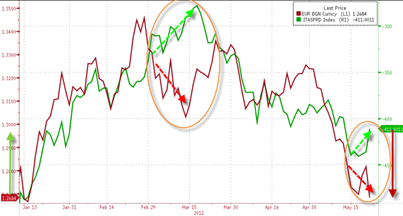

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')

!wget https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairs.py
import pairs as pairslib

# Yahoo Finance
!pip install yfinance
import yfinance as yf

# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)


# Display the stock info in Chinese or not
def useChinese(use=True):
  # return COL_NAME, COL_INDUSTRY, COL_SECTOR, AJD_CLOSE_FILE
  if use:
    return 'nameChi', 'industryChi', 'sectorChi', 'hkStocksAdjClosePxChi.csv'

  else:
    return 'shortName', 'industry', 'sector', 'hkStocksAdjClosePx.csv'


COL_NAME, COL_INDUSTRY, COL_SECTOR, AJD_CLOSE_FILE = useChinese(False)

In [ ]:
# Get the pre-downloaded all HK stocks information from yahoo
# Source the Chinese name and stock sectors from http://www1.hket.com/finance/chart/industry-index.do

# Get the stock information from Yahoo
#stockInfo = web.get_quote_yahoo(['0700.HK', '0005.HK', '0939.HK'])
#stockInfo

# Pandas support reading Excel directly
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
stocksInfo

In [ ]:
# Look at one stock
CODE = '0005.HK'
stocksInfo[(stocksInfo.code == CODE)]

In [ ]:
#@title Display in Chinese or not (** Needs to run this block after changes)
USE_CHINESE = True #@param {type:"boolean"}

COL_NAME, COL_INDUSTRY, COL_SECTOR, AJD_CLOSE_FILE = useChinese(USE_CHINESE)

In [ ]:
# list the unique industries names
industryNames = stocksInfo[COL_INDUSTRY].unique()
print('Count:', len(industryNames))
print(industryNames)

In [ ]:
# list the unique sector names
sectorNames = stocksInfo[COL_SECTOR].unique()
print('Count:', len(sectorNames))
print(sectorNames)

**Stock Selection**: choose the set of the stocks that wer are interested to trade in our portfolios

In [ ]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', COL_NAME, COL_INDUSTRY, COL_SECTOR, 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

In [ ]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', COL_NAME, COL_INDUSTRY, COL_SECTOR, 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

In [ ]:
# Industry Distribution with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[[COL_INDUSTRY, 'code']].groupby([COL_INDUSTRY]).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[[COL_INDUSTRY, COL_NAME]].groupby([COL_INDUSTRY])[COL_NAME].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[[COL_INDUSTRY, 'marketCap', 'turnover']].groupby([COL_INDUSTRY]).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on=COL_INDUSTRY, how='left')
industryInfo = industryInfo.merge(industryDetails, on=COL_INDUSTRY, how='left')

fig = px.pie(industryInfo, values='count', names=COL_INDUSTRY, hover_name=COL_NAME, title='Industry Distribution')
fig.show()

In [ ]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

In [ ]:
# download the daily stock price info (Open, High, Low, Close, Volume) from Yahoo
# split into 2 time frames (one for research and one for back-testing)
startDate = '2020-1-1'
endDate = '2020-12-31'
testStartDate = '2021-1-1'
allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")

# auto_adjust=True: The closing price is adjusted
# Tencent 5 for 1 split: https://www.stocksplithistory.com/?symbol=TCEHY
data = yf.download(allStockCodes, start=startDate, end=endDate, group_by='ticker', auto_adjust=True)
testData = yf.download(allStockCodes, start=testStartDate, group_by='ticker', auto_adjust=True)

columnNames = []
stocksDownload = []
testStocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo[COL_NAME]):
    if (code in data) and (code in testData):
      stocksDownload.append(data[code])
      testStocksDownload.append(testData[code])
      columnNames.append(name)

In [ ]:
# look at the downloaded stock price
company = "TENCENT"
#company = "騰訊控股" 

index = columnNames.index(company)
print(columnNames[index])
stocksDownload[index]

In [ ]:
# Combine the stocks adjusted closes to one pandas data frame 

# Testing period
adjCloses = [stock['Close'] for stock in testStocksDownload]
testStocks = pd.concat(adjCloses, axis=1)
testStocks.columns = columnNames


# Research period
adjCloses = [stock['Close'] for stock in stocksDownload]
stocks = pd.concat(adjCloses, axis=1)
stocks.columns = columnNames
stocks

In [ ]:
# Export the data to csv file for downloading
stocks.to_csv("hkStocksAdjClosePx.csv", encoding='utf_8_sig')

In [ ]:
# In case the Yahoo stock download failed, read from the prepared csv file
#stocks = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + AJD_CLOSE_FILE)
#columnNames = stocks.columns.to_list()[1:]
#stocks

In [ ]:
# Pick 2 stocks price chart to to show the price correlation in research period
stockA = 'TENCENT'
stockB = 'BABA-SW'
plotPair(stocks, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

**Pair Identifications**
*   Run the price correlation for all stock Pair combinations
*   Using the the default [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
*   The value is between 1 to -1 (**1**: perfectly positive correlated; **0**: No correlation; **-1**: perfectly negative correlated)

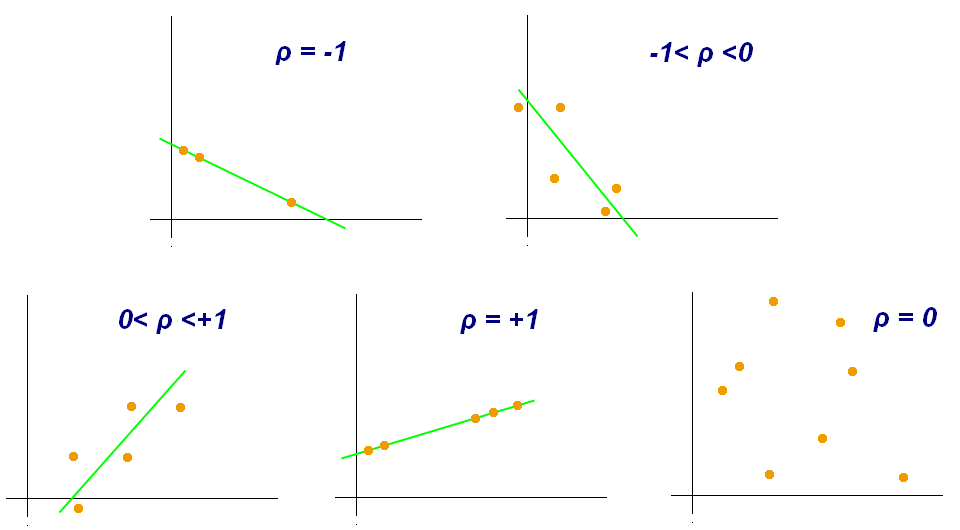 

In [ ]:
# Run the price correlation for all stock Pair combinations
stocksCorr = stocks.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# Filter the correlated stocks pair with the THRESHOLD
THRESHOLD = 0.95
highCorr = np.where(((stocksCorr >= THRESHOLD) & (stocksCorr < 1)))


#Found the price correlated pairs and store in a dataframe
pairsDf = pd.DataFrame(columns=['corr', 'stockA', 'stockB', 'sameSector', 'sectorA', 'sectorB'])
count = 0
pairs = {}

for i in range(len(highCorr[0])):
  a, b = highCorr[0][i], highCorr[1][i]
  revKey = str(b) + str(a)

  # prevent duplicated plot as (a,b) pair is the same as (b,a) pair
  if revKey not in pairs:
    # Get the sector from the Pair
    sectorA = stocksFilteredInfo.loc[stocksFilteredInfo[COL_NAME]==columnNames[a], COL_SECTOR].values[0]
    sectorB = stocksFilteredInfo.loc[stocksFilteredInfo[COL_NAME]==columnNames[b], COL_SECTOR].values[0]

    if sectorA == sectorB:
      sameSector = True
    else:
      sameSector = False

    # Construct the pair key id for comparing duplication
    key = str(a) +str(b)
    pairs[key] = [a, b]

    # Get the Pair correlation and store the details in a dataframe
    corr = round(stocksCorr.at[columnNames[a], columnNames[b]], 4)
    pairsDf.loc[count] = [corr, columnNames[a], columnNames[b], sameSector, sectorA, sectorB]
    count += 1

# shows the Pairs sorted by correlations
pairsDf = pairsDf.sort_values(by=['corr'], ascending=False)  
pairsDf      

In [ ]:
# Plot all the correlated Pairs with same sector
#plotManyPair(pairsDf[(pairsDf.sameSector == True)])

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 12

stockA = pairsDf.loc[selected_pair]['stockA']
stockB = pairsDf.loc[selected_pair]['stockB']
plotPair(stocks, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

In [ ]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']


AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
stocks[AB_stock] = stocks[PAIR_STOCK_A] / stocks[PAIR_STOCK_B]

stocks[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

**Trading Parameters**

* **Average Price Ratio of Stock A/B**: the average price ratio of the stock pair over the **research period** which represents **their long-term relationship**

* **Threshold**: define the **deviation boundary** for trade entry points 

* **Entry Point** (Divergence)

 * **Long A Short B**: **Buy under-value stock A** and **Short over-value stock B** when the stock pair price ratio is significantly **lower** (more than **threshold**) than the average price ratio 

 * **Short A Long B**: **Short over-value stock A** and **Buy under-value stock B** when the stock pair price ratio is significantly **higher** (more than **threshold**) than the average price ratio  

* **Exit Point** (Convergence)

 * **Rewind the Position**: if already entered the long/short positions, **reverse the above trade to close out the positions** when the stock pair price ratio **move back at the average price ratio**

In [ ]:
### Show the trading parameters in Research period

# Calculate the average Buy PAIR_STOCK_A / Sell PAIR_STOCK_B ratio
avgPxRatio = stocks[AB_stock].mean()
print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)


# Plot the averge price ratio in research period
stocks[AB_stock].plot(title='Research Period', label='Price Ratio', legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))
plt.axhline(y=avgPxRatio, label='Avg Price Ratio', color='b', linestyle='-')
plt.legend(loc ='upper right')


PX_RATIO_THRESHOLD = 0.05

longA_shortB_ratio = avgPxRatio * (1 - PX_RATIO_THRESHOLD)
labelLongAShortB = 'Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

shortA_longB_ratio = avgPxRatio * (1 + PX_RATIO_THRESHOLD)
labelShortALongB = 'Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) - Long A Short B: Buy", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Entry Point (Divergence) - Short A Long B: Short", PAIR_STOCK_A, "and Buy", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Exit Poiont (Convergence) - Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

In [ ]:
# Backtest the Pair in test period
params = {
    'PAIR_STOCK_A' : PAIR_STOCK_A,
    'PAIR_STOCK_B' : PAIR_STOCK_B,
    'avgPxRatio' : avgPxRatio,
    'shortA_longB_ratio' : shortA_longB_ratio,
    'longA_shortB_ratio' : longA_shortB_ratio,
    'dollarValue' : 10000
}


backTest_df = pairslib.backTest(testStocks, params)
cols = [params['PAIR_STOCK_A'], params['PAIR_STOCK_B'], 'ratio', 'signal', 'longValue', 'shortValue', 
        'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']

backTest_df[cols].round(2)

# signal == -1: Long A Short B
# signal == 1: Short A Long B

In [ ]:
# Plot the backtest result and PnL in test period
fig, axes = plt.subplots(2, 1)

backTest_df.ratio.plot(ax=axes[0], title='Test Period', label='Price Ratio', legend=True)
backTest_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
backTest_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)
axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].axhline(y=avgPxRatio, label='Avg Price Ratio', color='b', linestyle='-')
axes[0].legend(loc ='upper right', prop=CNFont)

backTest_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10))
axes[1].axhline(y=0, color='black', linestyle='-')

In [ ]:
''' Summary and suggestions

1. Stocks selection based on Turnover > 100 millon
Suggestion: Web scrape HKEx web site to exclude non short sell eligible stocks
   https://www.hkex.com.hk/Services/Trading/Securities/Securities-Lists/Designated-Securities-Eligible-for-Short-Selling?sc_lang=en


2. Use the adjusted closing price and pandas default corr function (Pearson correlation coefficient) to determine the stocks price correlations
Suggestion: Use Co-integration rather than price correlation
   https://blog.quantinsti.com/pairs-trading-basics/


3. Only choose the stock pairs with high correlation coefficient and from sector
Suggestion: Instead of using sector, use a clustering alogrithms (such as k-mean or DBScan) to group similar stocks together and trade Pairs only within the same cluster
   https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html


4. Calculate the strategy entry point if the current price ratio diverge more than the average price ratio (arithmetic average over a period) 
Suggestion: For the average price ratio, use moving average

'''